# Machine Learning in Python - Project 1

Due Friday, March 6th by 5 pm.

Adrian Lee, Abu Mazhar, Elliot Kovanda, Gianluca Bianchi

## 0. Setup

In [1]:
# Install required packages
!pip install -q -r requirements.txt

In [2]:
# Add any additional libraries or submodules below

# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn

In [5]:
# Load data
d = pd.read_csv("the_office.csv")
#importing second more up to date dataframe
d2 = pd.read_csv("the_office_series.csv")

## 1. Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a client). If you use any additional data sources, you should introduce them here and discuss why they were included.*

*Briefly outline the approaches being used and the conclusions that you are able to draw.*

,Unnamed: 0,Season,EpisodeTitle,About,Ratings,Votes,Viewership,Duration,Date,GuestStars,Director,Writers
0,0,1,pilot,The premiere episode introduces the boss and s...,7.5,4936,11.20,23,24 March 2005,NaN,Ken Kwapis,Ricky Gervais |Stephen Merchant and Greg Daniels
1,1,1,diversity day,Michael's off color remark puts a sensitivity ...,8.3,4801,6.00,23,29 March 2005,NaN,Ken Kwapis,B. J. Novak
2,2,1,health care,Michael leaves Dwight in charge of picking the...,7.8,4024,5.80,22,5 April 2005,NaN,Ken Whittingham,Paul Lieberstein
3,3,1,alliance,"Just for a laugh, Jim agrees to an alliance wi...",8.1,3915,5.40,23,12 April 2005,NaN,Bryan Gordon,Michael Schur
4,4,1,basketball,Michael and his staff challenge the warehouse ...,8.4,4294,5.00,23,19 April 2005,NaN,Greg Daniels,Greg Daniels
...,...,...,...,...,...,...,...,...,...,...,...,...
183,183,9,stairmageddon,Dwight shoots Stanley with a bull tranquilizer...,8.0,1985,3.83,22,11 April 2013,NaN,Matt Sohn,Dan Sterling
184,184,9,paper airplane,The employees hold a paper airplane competitio...,8.0,2007,3.25,22,25 April 2013,NaN,Jesse Peretz,Halsted Sullivan | Warren Lieberstein
185,185,9,livin' dream,Dwight becomes regional manager after Andy qui...,9.0,2831,3.51,42,2 May 2013,Michael Imperioli,Jeffrey Blitz,Niki Schwartz-Wright
186,186,9,a.a.r.m.,Dwight prepares for a marriage proposal and hi...,9.5,3914,4.56,43,9 May 2013,NaN,David Rogers,Brent Forrester


## 2. Exploratory Data Analysis and Feature Engineering

Before any major analysis or feature engineering we had to make sure the data we had was fit to use by means of cleaning it. The main effort was required when dealing with the 'episode name' and 'about' columns, ensuring that we had consistency with the spelling of words, as well as merging columns which contained the same information.

In [6]:
# data cleaning for episode names

# use lower case
d.episode_name = d.episode_name.apply(lambda x: x.lower())
d2.EpisodeTitle = d2.EpisodeTitle.apply(lambda x: x.lower())

# unify the spellings in the two data frames
d.episode_name = d.episode_name.str.replace('surveilance', 'surveillance')
d.episode_name = d.episode_name.str.replace('cover', 'cover-up')
d.episode_name = d.episode_name.str.replace('a.a.r.m', 'a.a.r.m.')
d.episode_name = d.episode_name.str.replace(' \(parts 1&2\)', '')
d2.EpisodeTitle = d2.EpisodeTitle.str.replace(': part 1', ' (part 1)')
d2.EpisodeTitle = d2.EpisodeTitle.str.replace(': part 2', ' (part 2)')
d.episode_name = d.episode_name.str.replace('&', 'and')
d.episode_name = d.episode_name.str.replace('s\*x', 'sex')

# remove the word "the" from episode names
d.episode_name = d.episode_name.str.replace('the ', '')
d2.EpisodeTitle = d2.EpisodeTitle.str.replace('the ', '')

# merge the `about` column of episodes that contains two parts
d2.loc[d2.EpisodeTitle.str.contains('delivery \(part 2\)'),'About'] = ' '.join(d2[d2.EpisodeTitle.str.contains('delivery')]['About'])
d2.loc[d2.EpisodeTitle.str.contains('niagara \(part 2\)'),'About'] = ' '.join(d2[d2.EpisodeTitle.str.contains('niagara')]['About'])

# only keep rows for the second part
d2 = d2.loc[~d2.EpisodeTitle.str.contains('delivery \(part 1\)')]
d2 = d2.loc[~d2.EpisodeTitle.str.contains('niagara \(part 1\)')]

# remove "(part 2)" from the episode names
d2.loc[d2.EpisodeTitle.str.contains('delivery \(part 2\)'), "EpisodeTitle"] = 'delivery'
d2.loc[d2.EpisodeTitle.str.contains('niagara \(part 2\)'), "EpisodeTitle"] = 'niagara'

# check whether there are still differences in episode names
set(d.episode_name.tolist()).symmetric_difference(set(d2.EpisodeTitle.tolist()))

set()

Now we have the clean data we merge the two data frames, using the most up to date values for imdb rating and votes.

In [8]:
# select columns of interest from the supplementary data frame
d2 = d2[["Ratings", "EpisodeTitle", "About", "Viewership", "Duration", "GuestStars", "Director"]]

# replace `imdb_rating` in the original dataframe with `Ratings` from the additional data frame, since the latter has a higher sample size
d.imdb_rating = d2.Ratings

# combine the two data frames using episode names
d = pd.merge(d, d2, left_on='episode_name', right_on='EpisodeTitle')

# drop `EpisodeTitle`
d = d.drop('EpisodeTitle', axis = 1)

### Feature Engineering: `n_lines`, `n_directions`, `n_words`, and `n_speak_char`

On inspection of the aforementioned variables we can see that they are correlated with eachother. This is an issue due to the fact that if we include all of them in our model we will likely obtain an unstable model which will not perfrom well on our test data. This correlation is seen in the pairplot below. The most highly correlated variables are those with the smallest confidence interval, in this case the 'n_lines' and 'n_words' variables. In order to account for this we introduce a new varibale, 'words_per_line', which encapsulates both of these features whilst reducing the variation of our model.

The confidence intervals between all the other variables were very large in comparison and we subsequentely decided that they were not correlated enough to be removed or altered.

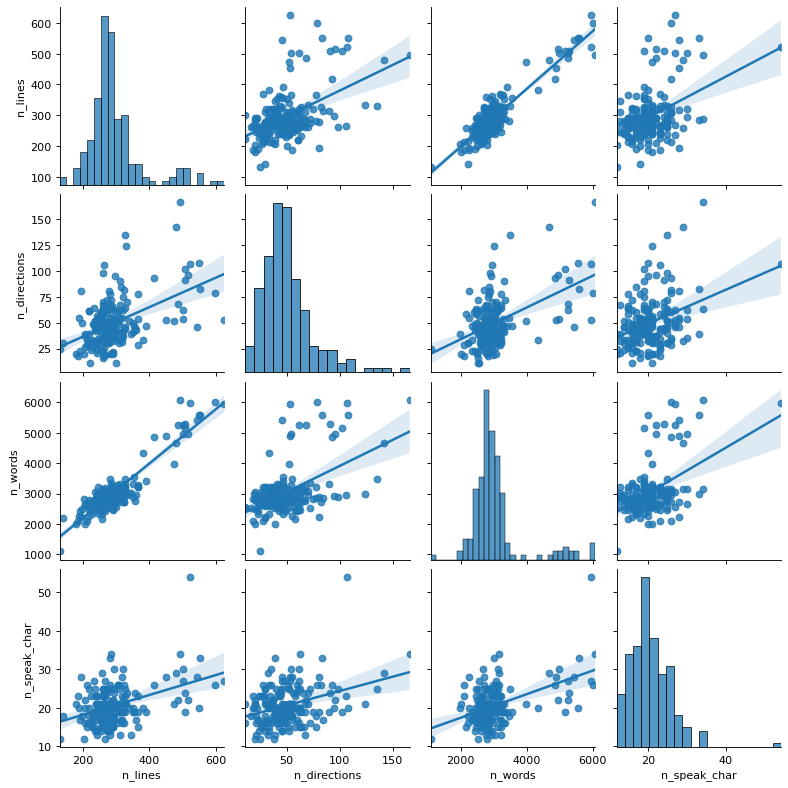

In [9]:
sns.pairplot(data=d,
            y_vars=["n_lines", "n_directions", "n_words", "n_speak_char"],
            x_vars=["n_lines", "n_directions", "n_words", "n_speak_char"],
            kind="reg");

In [10]:
# combine `n_words` and `n_lines` into one feature
d['words_per_line'] = d.n_words/d.n_lines

### Feature Engineering: `GuestStars` and `main_chars`

The first issue we encountered with these columns was the fact that they were both object types containing strings, which we cannot directly use in our model. The first step was to change `GuestStar` into a column which simply indicated the presence of a guest star or not. We chose this way as oppose to keeping the original names of the guest stars in order to ...

In [11]:
# change GuestStars from names into whether each episode features a guest star (binary: yes/no)
d.loc[pd.notnull(d.GuestStars),"GuestStars"] = 1
d.loc[pd.isnull(d.GuestStars),"GuestStars"] = 0

d.GuestStars = d.GuestStars.astype('int64');

We repated this process for the `main_char` variable so that each main character now has their own column indicating whether they were present in an episode or not.

In [15]:
# split `main_chars` column into multiple columns
main_chars_split = d.main_chars.str.split(expand=True, pat=';')
# find out the total number of episode each main character starred in
main_chars = pd.unique(main_chars_split.values.ravel('K'))
main_chars = main_chars[main_chars != None] # remove Nan's

for char in main_chars:
    d[char] = None
    
# one indicator variable for each `main_char`
for char in main_chars:
    for i in np.arange(0, len(d.main_chars), 1):
        if (char in d.main_chars[i]):
            d.at[i,char] = 1
        else:
            d.at[i,char] = 0

Upon analysis of the number of appearances of each character compared with their imdb rating we saw that for nearly all of them they had little effect on the episodes rating. However, we saw that the 

TypeError: No loop matching the specified signature and casting was found for ufunc svd_n_s

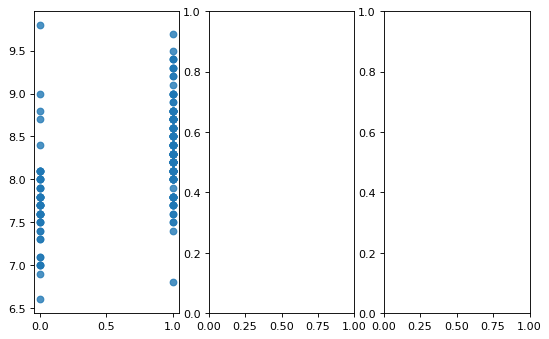

In [34]:
fig, axs = plt.subplots(ncols=3)
d['Michael'].astype(float)
d['Erin'].astype(float)
d['Kevin'].astype(float)
sns.regplot(x='Michael', y='imdb_rating', data=d, ax = axs[0])
sns.regplot(x='Erin', y='imdb_rating', data=d, ax =axs[1])
sns.regplot(x='Kevin', y='imdb_rating', data=d, ax = axs[2])

TypeError: No loop matching the specified signature and casting was found for ufunc svd_n_s

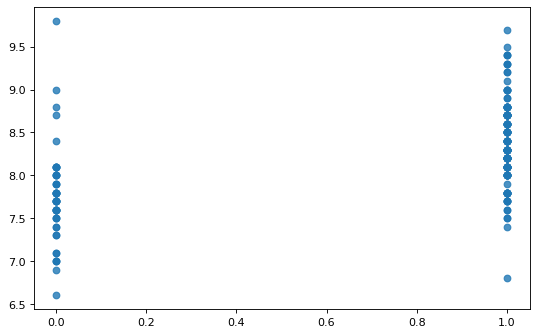

In [37]:
sns.regplot(x='Michael', y='imdb_rating', data=d)

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling. Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. Think carefully about whether each plot needs to be included in your final draft - your report should include figures but they should be as focused and impactful as possible.*

*Additionally, this section should also implement and describe any preprocessing / feature engineering of the data. Specifically, this should be any code that you use to generate new columns in the data frame `d`. All of this processing is explicitly meant to occur before we split the data in to training and testing subsets. Processing that will be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

*All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.*

## 3. Model Fitting and Tuning

*In this section you should detail your choice of model and describe the process used to refine and fit that model. You are strongly encouraged to explore many different modeling methods (e.g. linear regression, regression trees, lasso, etc.) but you should not include a detailed narrative of all of these attempts. At most this section should mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using and your process for tuning and validatin it.*

*For example if you considered a linear regression model, a classification tree, and a lasso model and ultimately settled on the linear regression approach then you should mention that other two approaches were tried but do not include any of the code or any in depth discussion of these models beyond why they were rejected. This section should then detail is the development of the linear regression model in terms of features used, interactions considered, and any additional tuning and validation which ultimately led to your final model.* 

*This section should also include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.*

## 4. Discussion & Conclusions


*In this section you should provide a general overview of your final model, its performance, and reliability. You should discuss what the implications of your model are in terms of the included features, predictive performance, and anything else you think is relevant.*

*This should be written with a target audience of a NBC Universal executive who is with the show and  university level mathematics but not necessarily someone who has taken a postgraduate statistical modeling course. Your goal should be to convince this audience that your model is both accurate and useful.*

*Finally, you should include concrete recommendations on what NBC Universal should do to make their reunion episode a popular as possible.*

*Keep in mind that a negative result, i.e. a model that does not work well predictively, that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explinations / justifications.*

## 5. Convert Document

In [ ]:
# Run the following to render to PDF
!jupyter nbconvert --to markdown project1.ipynb